In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import itertools
from typing import Tuple
from pprint import pprint
import json

**Part 0: Preparation**<br>
Building a validity checker<br>
Building a determining function<br>

<h3>012</h3>
<h3>345</h3>
<h3>678</h3>

In [79]:
def check_validity(state: str) -> bool: 
    """checks if a state is valid"""

    x_number = state.count('x')
    o_number = state.count('o')
    empty_number = state.count('_')
    #There should be at most 1 more x then o
    if (x_number < o_number) or (x_number - 1 > o_number):
        return False
    
    if (x_number + o_number + empty_number) != 9:
        return False

    #There can at most be one win
    x_win = False
    o_win = False

    #check diagonals
    if ((state[0] + state[4] + state[8]) == "ooo") or ((state[6] + state[4] + state[2]) == "ooo"):
        o_win = True
    elif ((state[0] + state[4] + state[8]) == "xxx") or ((state[6] + state[4] + state[2]) == "xxx"):
        x_win = True  


    #Check rows and cols
    for i in range(3):
        if (state[3 * i] + state[3 * i + 1] + state[3 * i + 2] == "xxx") or ((state[i] + state[3 + i] + state[6 + i] == "xxx")):
            x_win = True
        if (state[3 * i] + state[3 * i + 1] + state[3 * i + 2] == "ooo") or ((state[i] + state[3 + i] + state[6 + i] == "ooo")):
            o_win = True

    #if two players won, that's impossible
    if x_win and o_win:
        return False
    if x_win and (x_number == o_number):
        return False
    if o_win and (x_number > o_number):
        return False
    
    return True

def check_result(state: str) -> int:
    #check diagonals
    if ((state[0] + state[4] + state[8]) == "ooo") or ((state[6] + state[4] + state[2]) == "ooo"):
        return -1
    elif ((state[0] + state[4] + state[8]) == "xxx") or ((state[6] + state[4] + state[2]) == "xxx"):
        return 1
    #Check rows and cols
    for i in range(3):
        if (state[3 * i] + state[3 * i + 1] + state[3 * i + 2] == "xxx") or ((state[i] + state[3 + i] + state[6 + i] == "xxx")):
            return 1
        if (state[3 * i] + state[3 * i + 1] + state[3 * i + 2] == "ooo") or ((state[i] + state[3 + i] + state[6 + i] == "ooo")):
            return -1
    
    if state.count('_') > 0:
        return 2

    return 0

def display_state(state: str):
    """displays the state"""
    print(state[0] + state[1] + state[2])
    print(state[3] + state[4] + state[5])
    print(state[6] + state[7] + state[8])

Step 1:
Import Data Set

Step 2:
Create a dead empty Q-Table

Step 3:
Create helper functions

Step 4:
'Play The Game' Function

Step 5:
Training Function

Step 6:
Visualising Results

Step 7:
Result analysis

In [80]:
#Step 1 & 2:

def init_Q_Table(filename="results/list_of_all_possible_states.csv"):
    """Creates an empty Q_Table as a dictionary with numpy arrays of zeros"""
    
    Q_Table_read = pd.read_csv("results/list_of_all_possible_states.csv") #read the data set using pandas



    #Create an empty Q_Table
    Q_Table = dict()

    for state in Q_Table_read['state']:
        Q_Table[state] = np.zeros(9)

    return Q_Table


In [81]:
#Import Perfect Q_Table
def change_to_numpy(actions):
    """Changes a normal list to a numpy array"""
    actions = np.array(actions, dtype=float)
    return np.array(actions)

def import_perfect_Q_Table(filename="results/perfect_Q_Table.json"):
    """"Imports the perfect Q_Table that was generated using a different scirpt"""

    with open("results/perfect_Q_Table.json", "r", encoding="utf-8") as f:
        perfect_Q_Table = json.load(f)


    perfect_Q_Table = {state: change_to_numpy(action) for state, action in perfect_Q_Table.items()}

    return perfect_Q_Table

In [82]:
#Helper Functions
def return_valid_moves(state: str):
    """returns an array where 
    1 => possible to make a move
    0 => square is taken"""
    possible_moves = np.zeros(9)
    for i, move in enumerate(state):
        if move == '_':
            possible_moves[i] = 1
    
    return possible_moves

def pick_learning_move(Q_Table: dict, state:str, tau=np.e, player='x') -> int:
    """picks a random move from a list of possible moves
    uses the softmax function as weights
    """
    
    valid_moves = return_valid_moves(state)

    player_multiplier = 1 #x aims maximise the score
    if player == 'o':
        player_multiplier = -1 #o aims to minimise the score

    weights = np.power(tau, player_multiplier * Q_Table[state]) * valid_moves #generates weights using softmax(values)
    pick = np.random.choice(range(9), p=weights/weights.sum()) #picks random move using weights

    return pick

def pick_random_move(state: str) -> int:
    """This functions picks any random move in the game"""

    weights = return_valid_moves(state) #string x___o__x_ would give weights [0, 1, 1, 1, 0, 1, 1, 0, 1]
    pick = np.random.choice(range(9), p=weights/weights.sum()) 
    return pick


def pick_perfect_move(perfect_Q_Table: dict, state: str, player='x', random_perfect_move:bool = True) -> int:
    """This picks a random best possible move"""
    desired_move = np.nanmax(perfect_Q_Table[state]) #x aims to pick the move with the highest Q-value from all avaliable moves

    if player == 'o': #o aims to pick the move with the lowest Q-value from all avaliable moves
        desired_move = np.nanmin(perfect_Q_Table[state])

    possible_indices = [] #picking a random perfect move

    for i, move in enumerate(perfect_Q_Table[state]): #go through each move
        if move == desired_move:
            possible_indices.append(i) #add it to the list

            if random_perfect_move: #if we just want the first perfect move, return it
                return i

    return random.choice(possible_indices) 


def update_board(state:str, action, player='x') -> str:
    """returns a string which is the updated board, after a move(action) has been played"""
    state_list = list(state)
    state_list[action] = player
    state = ''.join(state_list)
    return state

def pick_maximum(Q_Table: dict, state: str):
    """finds the what is the best possible result you can achieve"""
    maximum = -1
    valid_moves = return_valid_moves(state)

    for i in range(9):
        if valid_moves[i] == 1:

            if Q_Table[state][i] > maximum:
                maximum = max(maximum, Q_Table[state][i])

    
    return maximum

def pick_minimum(Q_Table: dict, state: str):
    """finds the what is the worst possible result you can achieve"""
    minimum = 1
    valid_moves = return_valid_moves(state)

    for i in range(9):
        if valid_moves[i] == 1:

            if Q_Table[state][i] > minimum:
                minimum = min(minimum, Q_Table[state][i])
    
    return minimum


def learn_from_queue(Q_Table, queue, alpha=0.1, player='x'):
    """Updates the Q_Table based on the past games
    queue is a list which contains the game and the result
    game is a list which contains the states and the actions take
    """


    for game, result in queue: #goes through ever game in the queue

        for move_number, (state, action) in enumerate(game): #go through each state and action taken in the game

            if (move_number + 1) == len(game): #check if the game is terminated this turn
                Q_Table[state][action] += alpha * (result - Q_Table[state][action]) #If the game is terminated, the give immidiate reward as a resut

            else: #if the game is not terminated this turn
                #apply the formula:
                #   Q(state, action) = Q(state, action) + alpha [r + gamma * max/min Q(future state, future action) - Q(state, action)]
                #   alpha = learning rate
                #   gamma = discount rate
                #   maximum future reward for x, or minimum future reward for o
                next_state = game[move_number + 1][0] #next state 
                if player == 'x':
                    Q_Table[state][action] += alpha * (pick_maximum(Q_Table, next_state) - Q_Table[state][action]) # x aims to have most positive winning chances
                if player == 'o':
                    Q_Table[state][action] += alpha * (pick_minimum(Q_Table, next_state) - Q_Table[state][action]) # o aims to have most negative entries
    return Q_Table

def display_counter(counter):
    """displays the statistics over the last 100 games"""
    total = sum(counter) / 100
    print(f"{counter[0]/total:.2f}%   {counter[1]/total:.2f}%   {counter[2]/total:.2f}%")


In [83]:

def plot_triplet_ratios(data, component_labels=("A", "B", "C"), normalize=True, show=True):
    """
    Plot a list of 3-element lists (triplets) that (roughly) sum to 100.
    Produces two plots:
      1) Stacked area chart (normalized to 100 if requested)
      2) Line chart of each component over index

    Parameters
    ----------
    data : list[list[float]]
        Sequence of triplets, e.g. [[20, 40, 40], [10, 40, 50], [8, 38, 54], ...]
    component_labels : tuple[str, str, str]
        Names for the three components.
    normalize : bool
        If True, each triplet is scaled so its sum is exactly 100.
        If False, values are plotted as-is.
    show : bool
        If True, calls plt.show() at the end.
    """
    # Validate input
    arr = np.array(data, dtype=float)
    if arr.ndim != 2 or arr.shape[1] != 3:
        raise ValueError("`data` must be a 2D array-like with shape (n_samples, 3).")

    # Optionally normalize each row to sum to 100
    if normalize:
        row_sums = arr.sum(axis=1)
        # Avoid division by zero; keep rows with sum==0 as zeros
        with np.errstate(divide='ignore', invalid='ignore'):
            scale = np.where(row_sums == 0, 0, 100.0 / row_sums)
        arr = (arr.T * scale).T

    # Split components
    comp1, comp2, comp3 = arr.T
    x = np.arange(len(arr))* BATCH_SIZE * 100  # index (could be time or sample order)

    # --- Plot 1: Stacked area (stackplot) ---
    fig1, ax1 = plt.subplots(figsize=(9, 5))
    colors = ["#4C78A8", "#F58518", "#54A24B"]  # pleasant color palette
    ax1.stackplot(x, comp1, comp2, comp3, labels=component_labels, colors=colors, alpha=0.9)
    ax1.set_title("Stacked Area of Triplet Ratios" + (" (normalized to 100)" if normalize else ""))
    ax1.set_xlabel("Index")
    ax1.set_ylabel("Percent")
    ax1.set_ylim(0, max(100, arr.sum(axis=1).max()))  # ensure room if not normalized
    ax1.legend(loc="upper right")
    ax1.grid(True, alpha=0.25)

    # --- Plot 2: Line chart for each component ---
    fig2, ax2 = plt.subplots(figsize=(9, 5))
    ax2.plot(x, comp1, label=component_labels[0], color=colors[0], marker="o", linewidth=2)
    ax2.plot(x, comp2, label=component_labels[1], color=colors[1], marker="o", linewidth=2)
    ax2.plot(x, comp3, label=component_labels[2], color=colors[2], marker="o", linewidth=2)
    ax2.set_title("Win/Draw/Loss Distribution against random opponent" if normalize else "")
    ax2.set_xlabel("Index")
    ax2.set_ylabel("Percent")
    ax2.legend(loc="best")
    ax2.grid(True, alpha=0.25)

    plt.tight_layout()
    if show:
        plt.show()


In [84]:
#Functions related to playing the game

def play_the_game_learning(Q_Table, tau=np.e, player='x', perfect_opponent=False, perfect_Q_Table=dict()):
    """Playes the game and returns a queue of tuples"""
    queue = [] #Used for training
    state = "_________" #original state
    move_number = 0
    result = 2 #currently the game is being played
    player_index = 0 #x has a player index of 0, o has a player index of 1 
    oppostion = 'o'


    if player == 'o':
        player_index = 1
        oppostion = 'x'

    while result == 2: #While the game is still going

        if (move_number % 2) == player_index: #if it's the turn of the learning player
            action = pick_learning_move(Q_Table, state, tau, player) #play a learning move
            queue.append((state, action)) #record the state and the action take
            state = update_board(state, int(action), player) #update board

        else: #if  it's the turn of the computer player
            if perfect_opponent: #perfect opponent players perfect move
                action = pick_perfect_move(perfect_Q_Table, state, oppostion)
            else: #random opponent plays random move
                action = pick_random_move(state)
            state = update_board(state, action, oppostion) #Update board

        move_number += 1 

        result = check_result(state) #check if the result is now terminal
    return queue, result

def play_the_game_random(Q_Table, player='x'):
    """Playes the randomly from both sides game and returns a queue of tuples"""
    state = "_________"
    move_number = 0
    result = 2
    player_index = 0
    oppostion = 'o'


    while result == 2: #While the game is still going
        if (move_number % 2) == player_index: #x
            action = pick_random_move(state) #plays a random move
            state = update_board(state, action, player) 

        else: #o
            action = pick_random_move(state) #plays a random move
            state = update_board(state, action, oppostion)

        move_number += 1

        result = check_result(state) #checks if the result is terminal
    return result


In [85]:

BATCH_SIZE = 10
NUMBER_OF_BATCHES = 10000


def perform_training(player, opponent_type='perfect', number_of_batches=NUMBER_OF_BATCHES, batch_size=BATCH_SIZE, display_training=True):
    """trains a certain player on a certain strategy
    
    returns the trained Q-Table and the wins distribution as a np.matrix"""
    print('o win   draw    x win')
    Q_Table = init_Q_Table()

    counter_final_values = [] #list of how well the bot is performing
    counter = [0, 0, 0]

    if opponent_type == 'perfect':
        perfect_Q_Table = import_perfect_Q_Table()
    

    for batch_number in range(1, number_of_batches): #playes this many batches
        game_queue = [] #queue for the batch

        tau = calculate_tau(batch_number * batch_size) #decides on tau



        for game_number in range(batch_size): #plays through each batch
            
            if opponent_type == 'perfect':
                queue, result = play_the_game_learning(Q_Table,tau,  player, True, perfect_Q_Table) #plays the games against optimal opponent
            if opponent_type == 'random':
                queue, result = play_the_game_learning(Q_Table,tau,  player, False) #plays the games against random opponent               

            counter[result + 1] += 1 #updates the result counter

            game_queue.append((queue, result)) #adds the game to the qeue

        alpha = calculate_alpha(batch_number * batch_size)#calculates the learning rate


        Q_Table = learn_from_queue(Q_Table, game_queue, alpha, player) #learn (updates the Q_Table)

        if display_training:
            if batch_number % 200 == 0: #every hundred values, displays score
                counter_final_values.append(counter)
                print(int(batch_number))
                display_counter(counter)
                counter = [0, 0, 0]


    return Q_Table, np.array(counter_final_values)

def calculate_tau(turn) -> float:
    """calculates tau
    tau can change to prioritise exploitation over exploration"""
    
    tau = 1 + 2 * turn/100
    
    return float(tau)

def calculate_alpha(turn) -> float:
    """calculates alpha
    Alpha can be lowered to decrease the learning rate eventually"""
    
    alpha = 0.1#max(0.0001, 0.1 * np.exp(-0.0001 * turn))
    return float(alpha)



In [ ]:
output = perform_training('x', 'perfect', 3000, 10, True)
Q_Table_against_perfect_opponent = output[0]
result_distribution = output[1]
plot_triplet_ratios(result_distribution, component_labels=("Loss", "Draw", "Win"), normalize=True)

o win   draw    x win
200
79.00%   21.00%   0.00%
400
81.00%   19.00%   0.00%
600
72.50%   27.50%   0.00%
800
76.50%   23.50%   0.00%
1000
74.00%   26.00%   0.00%
1200
71.00%   29.00%   0.00%
1400
68.50%   31.50%   0.00%
1600
66.50%   33.50%   0.00%
1800
56.50%   43.50%   0.00%
2000
53.50%   46.50%   0.00%
2200
55.50%   44.50%   0.00%
2400
59.50%   40.50%   0.00%
2600
50.00%   50.00%   0.00%
2800
51.00%   49.00%   0.00%
3000
50.00%   50.00%   0.00%
3200
44.00%   56.00%   0.00%
3400
39.50%   60.50%   0.00%
3600
40.50%   59.50%   0.00%
3800
35.50%   64.50%   0.00%
4000
37.00%   63.00%   0.00%
4200
42.50%   57.50%   0.00%
4400
32.50%   67.50%   0.00%
4600
32.50%   67.50%   0.00%
4800
22.50%   77.50%   0.00%
5000
31.00%   69.00%   0.00%
5200
26.50%   73.50%   0.00%
5400
26.50%   73.50%   0.00%
5600
26.00%   74.00%   0.00%
5800
24.50%   75.50%   0.00%
6000
21.50%   78.50%   0.00%
6200
23.50%   76.50%   0.00%
6400
23.00%   77.00%   0.00%
6600
21.00%   79.00%   0.00%


KeyboardInterrupt: 

[0.9815 0.9805 0.98   0.978  0.9705 0.9705 0.968  0.962  0.9625 0.9565
 0.959  0.9505 0.9525 0.9525 0.949  0.945  0.9395 0.942  0.9415 0.9375
 0.9375 0.9305 0.925  0.9275 0.9295 0.9275 0.9195 0.923  0.923  0.924
 0.9265 0.9235 0.919  0.9185 0.9195 0.922  0.9165 0.921  0.9165 0.919
 0.918  0.9135 0.9145 0.9145 0.919  0.916  0.908  0.9125 0.915  0.919
 0.9125 0.911  0.913  0.9135 0.9085 0.908  0.91   0.909  0.911  0.91
 0.909  0.909  0.91   0.907  0.9095 0.9095 0.9075 0.9085 0.9085 0.9075
 0.9115 0.9045 0.9065 0.907  0.9065 0.9075 0.9075 0.9085 0.9045 0.905
 0.9105 0.9065 0.9065 0.906  0.9085 0.908  0.9085 0.906  0.9075 0.906
 0.9035 0.904  0.905  0.9035 0.9055 0.9045 0.9045 0.9055 0.9045 0.9075
 0.904  0.9035 0.907  0.906  0.9055 0.9025 0.9055 0.9045 0.9045 0.903
 0.9035 0.905  0.908  0.904  0.905  0.9035 0.906  0.903  0.9045 0.902
 0.906  0.9025 0.9045 0.9055 0.906  0.9025 0.9025 0.9045 0.905  0.907
 0.9025 0.9045 0.9045 0.9015 0.905  0.9045 0.9045 0.904  0.903  0.9035
 0.902  0.904  0

Text(0.5, 1.0, '0.9636518469816909')

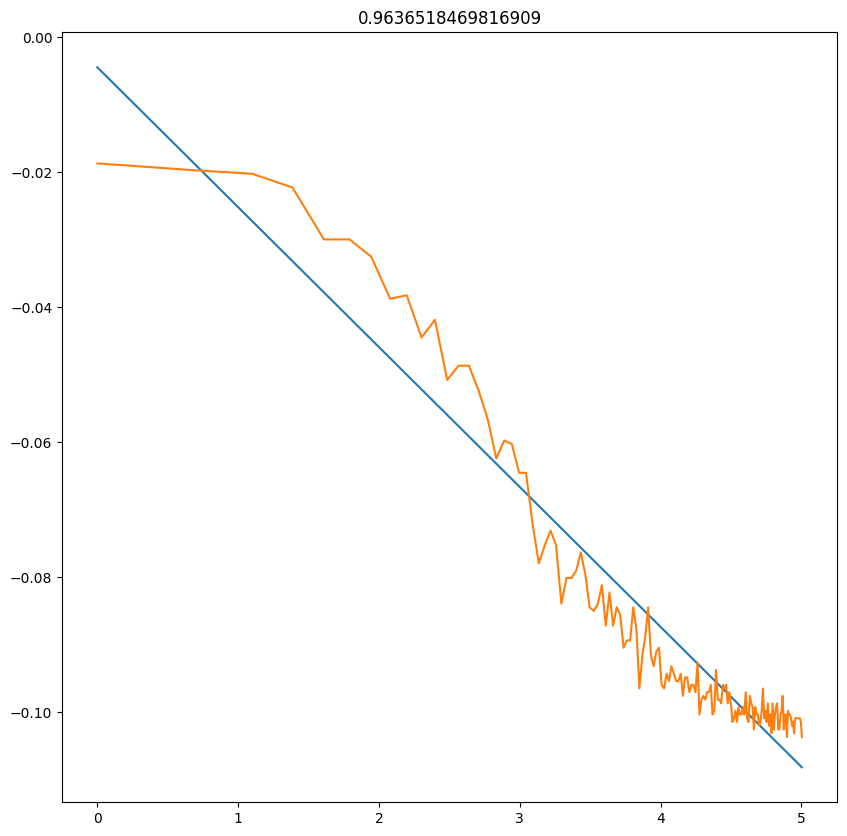

In [ ]:
fig, axes = plt.subplots(figsize=(10, 10))

x = np.arange(1, result_distribution.shape[0] + 1)
y = 1 - result_distribution[:, 1]/2000 

print(y)
A = np.array([np.ones_like(x), np.log(x)]).T
params = np.linalg.lstsq(A, np.log(y))[0]
y_hat = params[0] + np.log(x) * params[1]

plt.plot(np.log(x), y_hat)
plt.plot(np.log(x), np.log(y))
plt.title(np.corrcoef(np.log(y), y_hat )[0, 1])